In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [69]:
#directory = '../data/Sofia-Eindhoven/'
directory = '../data/multiple_data/'

all_dfs = []

for filename in os.listdir(directory):
    #print(filename)
    df = pd.read_csv(directory + filename)

    df["Price at Date"] = pd.to_datetime(df["Price at Date"], format="%Y/%m/%d")


    if df["Price in EUR"].max() != df["Price in EUR"].min():
        all_dfs.append((filename[:-4], df))

#all_dfs.sort(key=lambda x : int(x[0].split(' ')[0]))
#print(all_dfs)

In [70]:
#have normalized y

for name, cur_dfs in all_dfs:
    cur_dfs["normalized"] = (cur_dfs["Price in EUR"] - cur_dfs["Price in EUR"].min()) / (cur_dfs["Price in EUR"].max() - cur_dfs["Price in EUR"].min())

display(all_dfs[0])


('Rome-Amsterdam-14',
    Price at Date  Price in EUR  normalized
 0     2023-06-08           106    0.196078
 1     2023-06-09           100    0.156863
 2     2023-06-10            96    0.130719
 3     2023-06-11            96    0.130719
 4     2023-06-12            96    0.130719
 ..           ...           ...         ...
 60    2023-08-07           164    0.575163
 61    2023-08-08           166    0.588235
 62    2023-08-09           154    0.509804
 63    2023-08-10           166    0.588235
 64    2023-08-11           229    1.000000
 
 [65 rows x 3 columns])

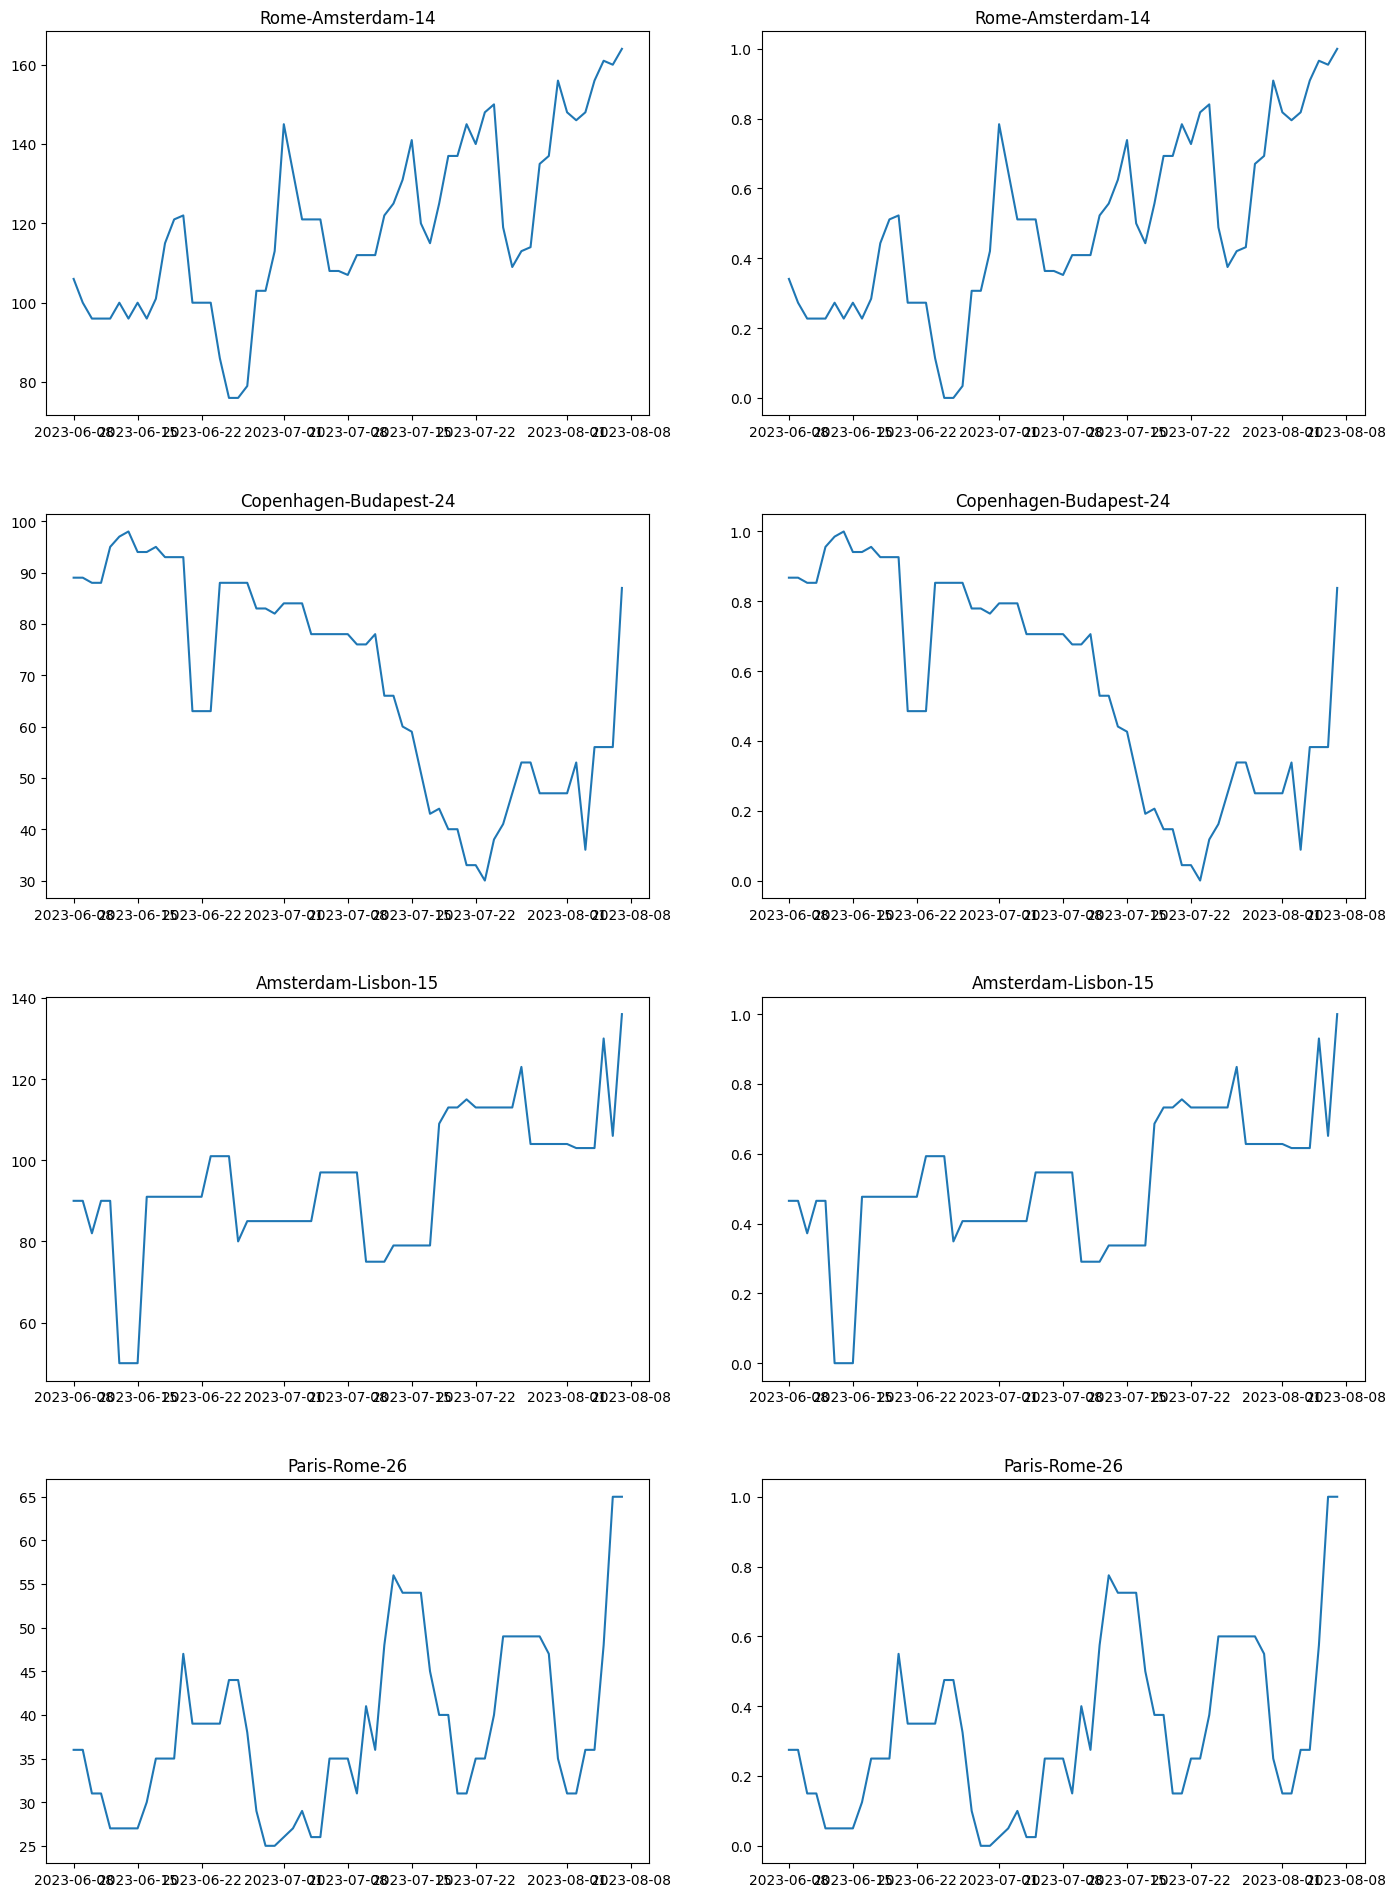

In [4]:
fig, ax = plt.subplots(len(all_dfs[:4]), 2)

fig.set_size_inches((15, 20))
fig.tight_layout(pad=5.0)

for ind, (name, df) in enumerate(all_dfs[:4]):
    ax[ind][0].plot(df["Price at Date"], df["Price in EUR"])
    ax[ind][0].title.set_text(name)

    ax[ind][1].plot(df["Price at Date"], df["normalized"])
    ax[ind][1].title.set_text(name)


In [71]:
#sliding window approach
WINDOW_SIZE_X = 17
WINDOW_SIZE_y = 2

np_frames = [x[1].to_numpy() for x in all_dfs]

df_data = pd.DataFrame({
    "window_X":[[]],
    "window_y":[[]]
})

for cur_frame in np_frames:
    cur_len = len(cur_frame)

    for start_from in range(0, cur_len - WINDOW_SIZE_X - WINDOW_SIZE_y, 1):
        df_data.loc[len(df_data)] = [np.array(cur_frame[start_from:start_from + WINDOW_SIZE_X, 2]), np.array(cur_frame[start_from + WINDOW_SIZE_X:start_from+WINDOW_SIZE_X+WINDOW_SIZE_y, 2])]

df_data = df_data.drop([0])
display(len(df_data))
display(df_data)

96268

,window_X,window_y
1,"[0.19607843137254902, 0.1568627450980392, 0.13...","[0.0, 0.0]"
2,"[0.1568627450980392, 0.13071895424836602, 0.13...","[0.0, 0.0196078431372549]"
3,"[0.13071895424836602, 0.13071895424836602, 0.1...","[0.0196078431372549, 0.17647058823529413]"
4,"[0.13071895424836602, 0.13071895424836602, 0.1...","[0.17647058823529413, 0.17647058823529413]"
5,"[0.13071895424836602, 0.1568627450980392, 0.13...","[0.17647058823529413, 0.24183006535947713]"
...,...,...
96264,"[0.058823529411764705, 0.1715686274509804, 0.1...","[0.4215686274509804, 0.5294117647058824]"
96265,"[0.1715686274509804, 0.17647058823529413, 0.32...","[0.5294117647058824, 0.31862745098039214]"
96266,"[0.17647058823529413, 0.3235294117647059, 0.38...","[0.31862745098039214, 0.3235294117647059]"
96267,"[0.3235294117647059, 0.3872549019607843, 0.299...","[0.3235294117647059, 0.44607843137254904]"


In [72]:
# split data into train and validation
from sklearn.model_selection import train_test_split

#np_data = df_data.to_numpy()

print(df_data["window_X"].isnull().sum())

X_train, X_test, y_train, y_test = train_test_split(df_data["window_X"].to_numpy(), df_data["window_y"].to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

0
(86641,)
(9627,)
(86641,)
(9627,)


In [78]:
import tensorflow as tf
from tensorflow import keras

EPOCHS = 20
BATCH_SIZE = 64

def build_model():
    model = tf.keras.models.Sequential()
    model.add(keras.layers.Dense(50, input_shape=(WINDOW_SIZE_X,),name='dense_layer', activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

    model.add(keras.layers.Dense(60,name='dense_layer_2', activation='sigmoid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10,name='dense_layer_3', activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.Dense(WINDOW_SIZE_y,name='output_layer', activation='linear'))
    return model

model = build_model()

model.summary()
model.compile(optimizer = "adam", loss = "mean_squared_error",
    metrics = ["mean_squared_error"]
)

X_train_2 = [list(z) for z in X_train[:]]
y_train_2 = [list(z) for z in y_train[:]]

X_test_2 = [list(z) for z in X_test[:]]
y_test_2 = [list(z) for z in y_test[:]]

history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_2, y_test_2))

score = model.evaluate(X_test_2, y_test_2, batch_size=BATCH_SIZE)

print("\nTest score:", score[0])
print('Test accuracy:', score[1])

print(history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 50)                900       
                                                                 
 dense_layer_2 (Dense)       (None, 60)                3060      
                                                                 
 dropout_6 (Dropout)         (None, 60)                0         
                                                                 
 dense_layer_3 (Dense)       (None, 10)                610       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 output_layer (Dense)        (None, 2)                 22        
                                                                 
Total params: 4592 (17.94 KB)
Trainable params: 4592 (

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


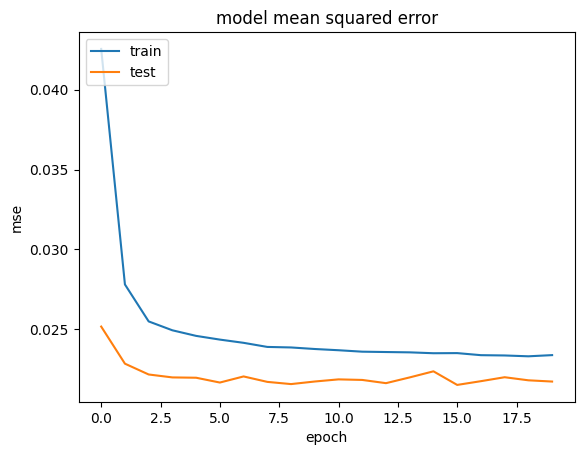

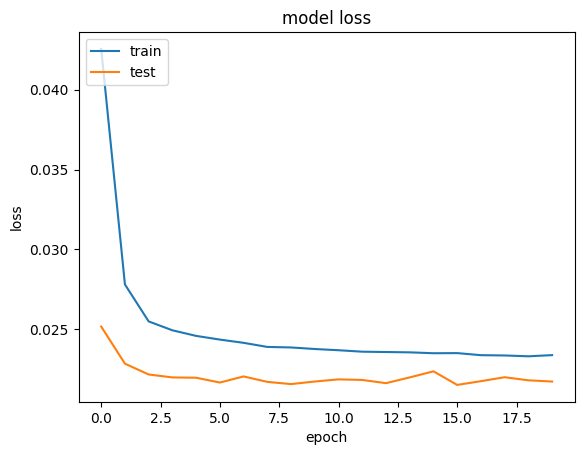

In [79]:
print(history.history.keys())

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 19ms/step


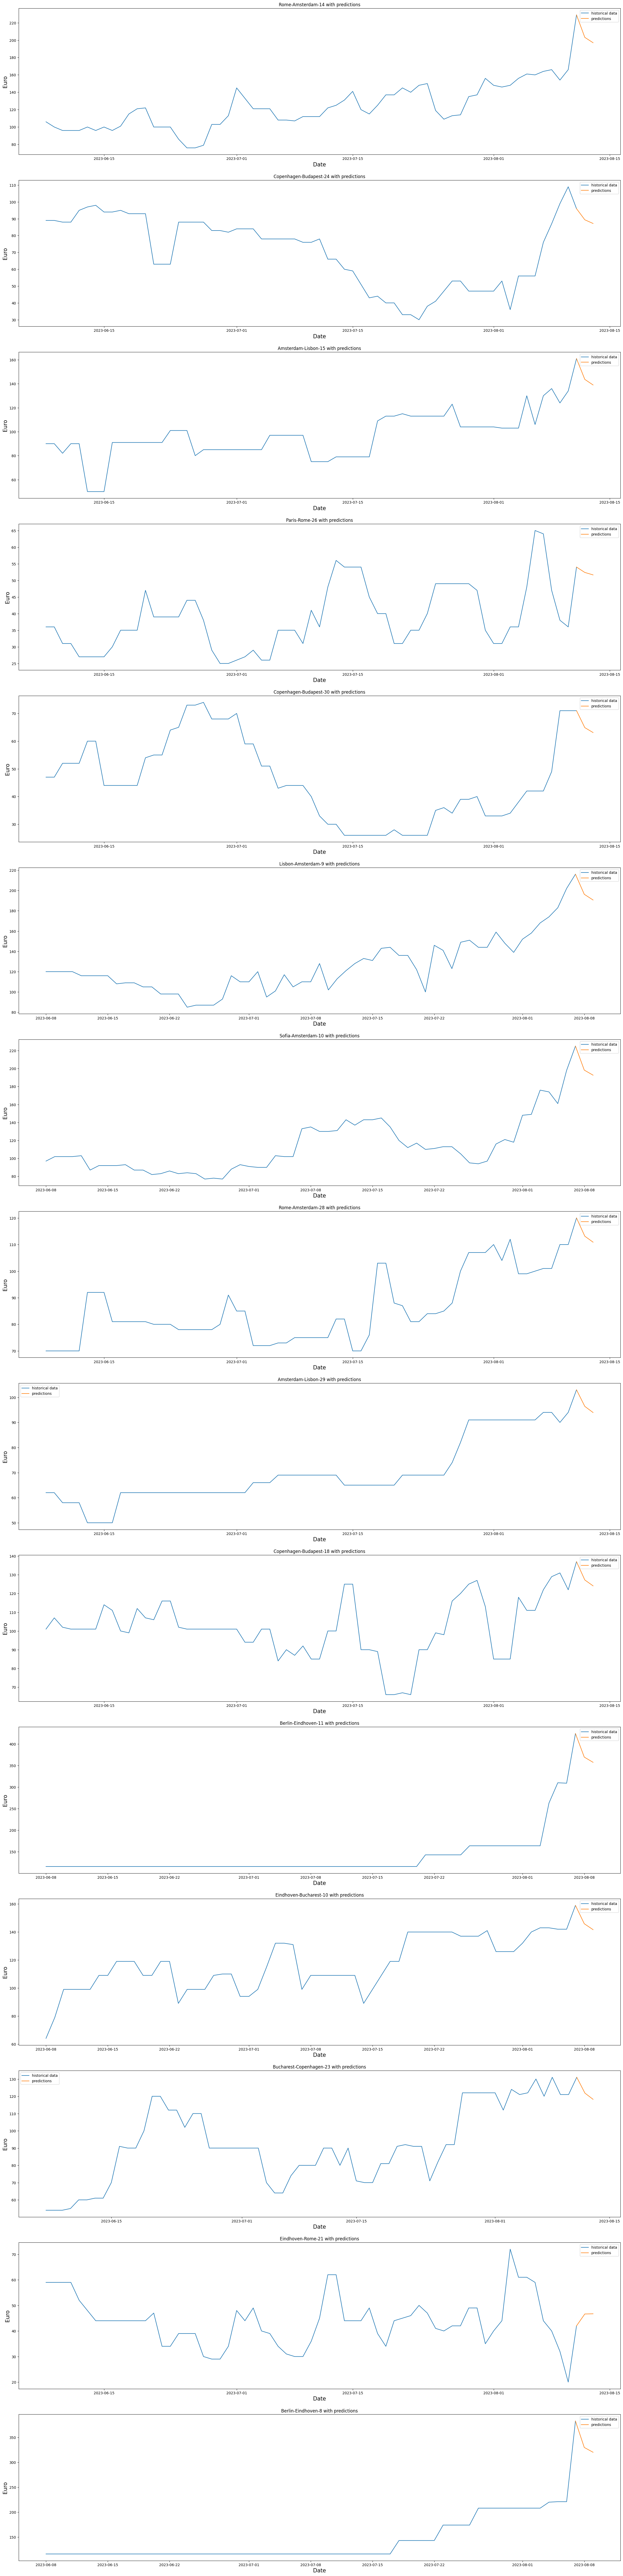

In [80]:
# use regressor to continue function
TO_DISPLAY = 15

fig, ax = plt.subplots(TO_DISPLAY)

fig.set_size_inches((25, 100))
fig.tight_layout(pad=5.0)

for ind, (name, df) in enumerate(all_dfs[:TO_DISPLAY]):
    ax[ind].plot(df["Price at Date"], df["Price in EUR"], label='historical data')

    cur_pred = df["normalized"].to_numpy()[-WINDOW_SIZE_X:]
    predicted_values = model.predict([list(cur_pred)])

    last_date = df["Price at Date"].to_numpy()[-1]
    updated_df = [last_date]

    for x in range(0, WINDOW_SIZE_y):
        last_date += np.timedelta64(1, 'D')

        updated_df.append(last_date)
    predicted_values = np.insert(predicted_values, 0, df["normalized"].to_numpy()[-1])

    # denormalize predicted_values

    predicted_values *= (df["Price in EUR"].max() - df["Price in EUR"].min())

    predicted_values += df["Price in EUR"].min()
        
    ax[ind].plot(updated_df, predicted_values.reshape(-1, 1), label='predictions')
    ax[ind].title.set_text(name + " with predictions")
    ax[ind].legend()

    ax[ind].set_xlabel('Date', fontsize=15)
    ax[ind].set_ylabel('Euro', fontsize=15)
